In [2]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Загрузка данных
data = pd.read_csv("output.csv", sep='\t')

# Разделение данных на обучающую и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.1, random_state=64)

# Предобработка текста
stop_words = stopwords.words('russian')
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    text = str(text).lower()
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

train_data['Text'] = train_data['Text'].apply(preprocess_text)
test_data['Text'] = test_data['Text'].apply(preprocess_text)

In [7]:
# Векторизация текста
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data['Text'])
test_vectors = vectorizer.transform(test_data['Text'])

In [9]:
# Выбор и обучение модели
model = LogisticRegression()
model.fit(train_vectors, train_data['Score'])

# Предсказания на тестовой выборке
predictions = model.predict(test_vectors)

# Оценка модели
accuracy = accuracy_score(test_data['Score'], predictions)
print(f"Accuracy: {accuracy}")



Accuracy: 0.9702496582487948


In [10]:
# Сохранение модели
joblib.dump(model, 'sentiment_model.pkl')

# Загрузка модели (при необходимости)
# model = joblib.load('sentiment_model.pkl')

['sentiment_model.pkl']

Top 10 positive words:
спасиб: 21.524316646034475
благодарн: 15.425413866298525
быстр: 14.829247275766217
благодар: 14.020459074834285
оперативн: 12.71367412541083
помогл: 12.248497029742385
приятн: 11.857305267428782
спасибо: 11.542937051382546
быстро: 11.521040568159373
удобн: 9.525371483685607

Top 10 negative words:


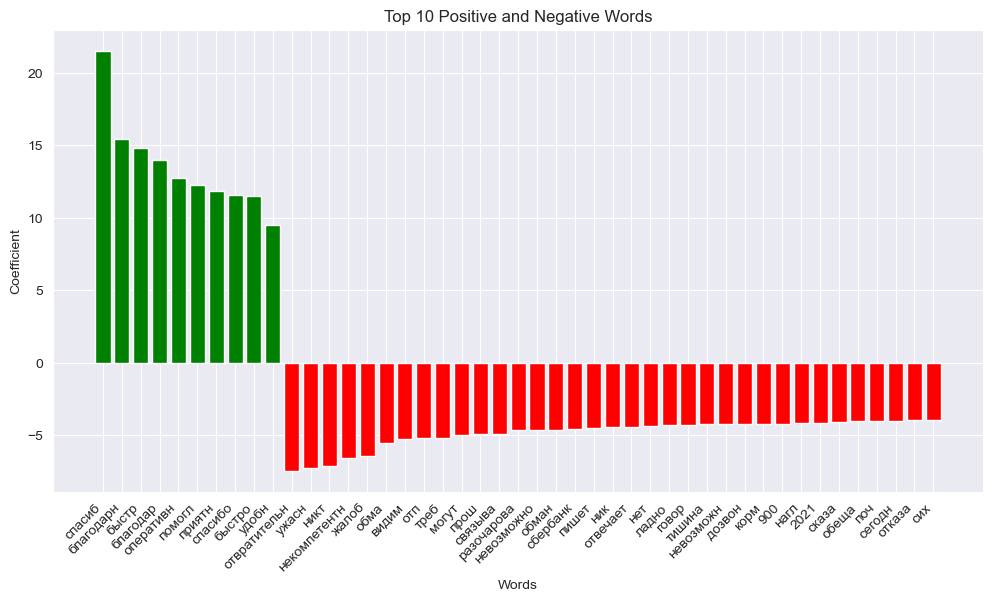

In [14]:
# Интерпретация результатов
# Вывод наиболее важных признаков (слов) для каждого класса
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]
sorted_coefs = sorted(zip(coefs, feature_names), key=lambda x: abs(x[0]), reverse=True)

# Вывод топ-10 положительных и отрицательных слов
print("Top 10 positive words:")
for coef, feature in sorted_coefs[:10]:
    if coef > 0:
        print(f"{feature}: {coef}")

print("\nTop 10 negative words:")
for coef, feature in sorted_coefs[:10]:
    if coef < 0:
        print(f"{feature}: {coef}")

# Визуализация важных признаков
# Пример: гистограмма топ-10 положительных и отрицательных слов
top_positive_words = [feature for coef, feature in sorted_coefs[:10] if coef > 0]
top_positive_coefs = [coef for coef, feature in sorted_coefs[:10] if coef > 0]
top_negative_words = [feature for coef, feature in sorted_coefs[:100] if coef < 0]
top_negative_coefs = [coef for coef, feature in sorted_coefs[:100] if coef < 0]

plt.figure(figsize=(12, 6))
plt.bar(top_positive_words, top_positive_coefs, color='green')
plt.bar(top_negative_words, top_negative_coefs, color='red')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Positive and Negative Words")
plt.xlabel("Words")
plt.ylabel("Coefficient")
plt.show()


In [12]:

# Анализ ошибок
# Можно вывести примеры неправильно классифицированных отзывов для дальнейшего анализа и улучшения модели
incorrect_predictions = test_data[test_data['Score'] != predictions]
print("\nExamples of incorrect predictions:")
print(incorrect_predictions[['Text', 'Score']].head(10))


Examples of incorrect predictions:
                                                     Text     Score
740     карт халв хран сво деньги, котор банк кажд мес...  Negative
169650  явля клиент банк 2х лет. реш закр накопительн ...  Negative
134860  так ситуация, оформ карт аукцион ссылке(он еди...  Positive
83879   нача того, смог заказа обед сберспасибо. нача ...  Positive
103598  месяц назад приобрел автомобил рассрочк совком...  Positive
235494  явля клиент банк ""русск стандарт"" окол 5 лет...  Negative
63628   добр день. сентябр реш попробова премиальн обс...  Negative
168326  клиент почта-банка. никак обязательств ним, зв...  Positive
6400    оформлен автокредит банк навязыва использован ...  Negative
254510  здравствуйте. оставля 3 заявк сайт восточн бан...  Negative


confusion matrix для просмотра так ли точно работает модель



Confusion Matrix:
[[11605   248]
 [  579 15366]]


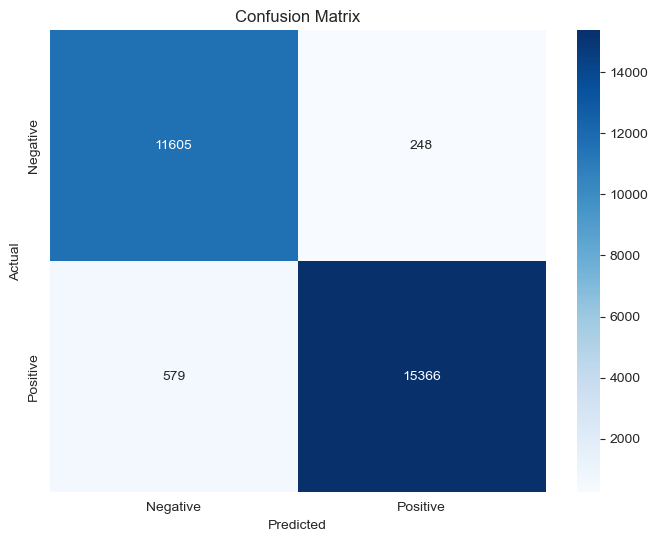

In [13]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(test_data['Score'], predictions)
print(f"Confusion Matrix:\n{cm}")

# Визуализация confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()